In [1]:
import pandas as pd
import duckdb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import os 
from dotenv import load_dotenv
from pathlib import Path
load_dotenv()

True

In [5]:
DB_PATH = Path(os.getenv("DB_PATH"))
DB_FILE = os.getenv("DB_FILE")
duckdb_path = DB_PATH / DB_FILE

In [6]:
con = duckdb.connect(duckdb_path, read_only=True)
df = con.execute("SELECT * FROM Headlines.weekly_training_data").fetchdf()
con.close()

In [5]:
def classify_price_movement(y):
    if y <= -5.0:
        return -2  # Huge Drop
    elif -5.0 < y <= -2.5:
        return -1  # Moderate Drop
    elif -2.5 < y < 2.5:
        return 0   # No Impactful Change
    elif 2.5 <= y < 5.0:
        return 1   # Moderate Surge
    else:
        return 2   # Major Surge

def plot_cm(cm):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_importance(features, X_train):    
    feature_importance_df = pd.DataFrame(
        {"Feature": X_train.columns, "Importance": features}
    ).sort_values(by="Importance", ascending=False)

    # Display top features
    print(feature_importance_df.head(20))  

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance_df["Feature"].head(20), feature_importance_df["Importance"].head(20))
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Top 20 Most Important Features in XGBoost Model")
    plt.gca().invert_yaxis()
    plt.show()

In [6]:
# Sort data by date and ticker before shifting
df = df.sort_values(by=["ticker", "date_t"])

# Shift `price_change_t_7` backwards to create `price_change_t_7_future`
df["price_change_t_7_future"] = df.groupby("ticker")["price_change_t_7"].shift(-1)

# Drop rows where `price_change_t_7_future` is NaN (since we don't have future data for the last row)
df = df.dropna(subset=["price_change_t_7_future"])

df["Target_t_7"] = df["price_change_t_7_future"].apply(classify_price_movement)
df = df.drop(columns=["price_change_t_7_future"])

df["Target_t_7"].value_counts() # honestly this is pretty balanced

Target_t_7
 0    165338
 1     12500
-1     11285
-2      4066
 2      3837
Name: count, dtype: int64

In [ ]:
# drop rows that have -1 for price_t, price_t_7_past, volume_t, volume_t_7_past
print(f"Before removing -1s {df.shape}")
filtered_df = df[(df["price_t"] != -1) & (df["price_t_7_past"] != -1) & (df["volume_t"] != -1) & (df["volume_t_7_past"] != -1)]
print(f"After removing -1s {filtered_df.shape}")

# remove everything with subindustry as null 
print(f"Before removing nulls {filtered_df.shape}")
filtered_df = filtered_df[filtered_df["subindustry"].notnull()]
print(f"After removing nulls {filtered_df.shape}")

In [ ]:
filtered_df["Target_t_7"].value_counts() # honestly this is pretty balanced

In [ ]:
# see what rows have NaN values 
filtered_df[filtered_df.isna().any(axis=1)]
# okay looks like we have one weird case where no volume data for BIIB @ 2023-06-12 so its NaN??? lets make it 0 I guess 
filtered_df["volume_change_t_7"] = filtered_df["volume_change_t_7"].fillna(0)
# filtered_df[filtered_df.isna().any(axis=1)]


handle categorical

In [ ]:
categorical_features = ["ticker", "subindustry"]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_cats = encoder.fit_transform(filtered_df[categorical_features])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

In [ ]:
processed_df = filtered_df.drop(columns=categorical_features)
processed_df = processed_df.drop(columns=["guid", "sentiment_label_t"])
# processed_df = pd.concat([processed_df, encoded_df], axis=1)
processed_df.columns

In [ ]:
scaler = StandardScaler()

date_col = processed_df["date_t"].reset_index(drop=True)  # Reset index
target_col = processed_df["Target_t_7"].reset_index(drop=True)  # Reset index
processed_df_no_date = processed_df.drop(columns=["date_t", "Target_t_7"]).reset_index(drop=True)

scaled_features = scaler.fit_transform(processed_df_no_date)
scaled_df = pd.DataFrame(scaled_features, columns=processed_df_no_date.columns)
print(scaled_df[scaled_df.isna().any(axis=1)].size)
if date_col.index.equals(scaled_df.index) and target_col.index.equals(scaled_df.index):
    scaled_df = pd.concat([date_col, scaled_df, target_col], axis=1)    
    print(scaled_df.columns)
else:
    raise ValueError("Index mismatch")

In [11]:
final_df = pd.concat([scaled_df, encoded_df], axis=1)
final_df.head()

,date_t,vix_t,vix_t_7_past,vix_t_7_future,price_t,price_t_7_past,price_change_t_7,volume_t,volume_t_7_past,volume_change_t_7,...,subindustry_60105010,subindustry_60106010,subindustry_60106020,subindustry_60107010,subindustry_60108010,subindustry_60108020,subindustry_60108030,subindustry_60108040,subindustry_60108050,subindustry_60201040
0,2022-01-03,0.010515,-0.252265,0.078001,-0.009629,0.001219,-0.956811,-0.189226,-0.193526,0.299572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-10,0.083972,0.010724,1.728778,-0.047068,-0.046773,-0.031193,-0.165006,-0.176720,0.325534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-17,1.734172,0.084156,1.525422,-0.048656,-0.048329,-0.034396,-0.173303,-0.172948,-0.044130,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-24,1.530886,1.733813,0.766679,-0.070352,-0.072060,0.171682,-0.175108,-0.180791,0.184847,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-31,0.772409,1.530594,1.474155,-0.066383,-0.073550,0.731616,-0.186741,-0.174093,-0.381458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# find unique dates 
final_df = final_df.sort_values(by="date_t", ascending=True)
dates = final_df["date_t"].unique()
print(len(dates) * 0.8)
print(dates[108])

# so the middle is at index 108 
train_dates = dates[:108]
test_dates = dates[108:]

train_df = final_df[final_df["date_t"].isin(train_dates)]
test_df = final_df[final_df["date_t"].isin(test_dates)]

X_train = train_df.drop(columns=["Target_t_7", "date_t"])
y_train = train_df["Target_t_7"]

X_test = test_df.drop(columns=["Target_t_7", "date_t"])
y_test = test_df["Target_t_7"]

107.2
2024-01-29 00:00:00


In [13]:
model = LogisticRegression(class_weight="balanced", max_iter=1000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.20      0.25      0.22       330
          -1       0.07      0.04      0.05       950
           0       0.92      0.75      0.83     21863
           1       0.07      0.20      0.11      1273
           2       0.08      0.43      0.14       482

    accuracy                           0.68     24898
   macro avg       0.27      0.34      0.27     24898
weighted avg       0.82      0.68      0.74     24898



[[   84    18    69    60    99]
 [   29    42   544   154   181]
 [  201   507 16446  2961  1748]
 [   29    47   640   257   300]
 [   77    23    81    95   206]]


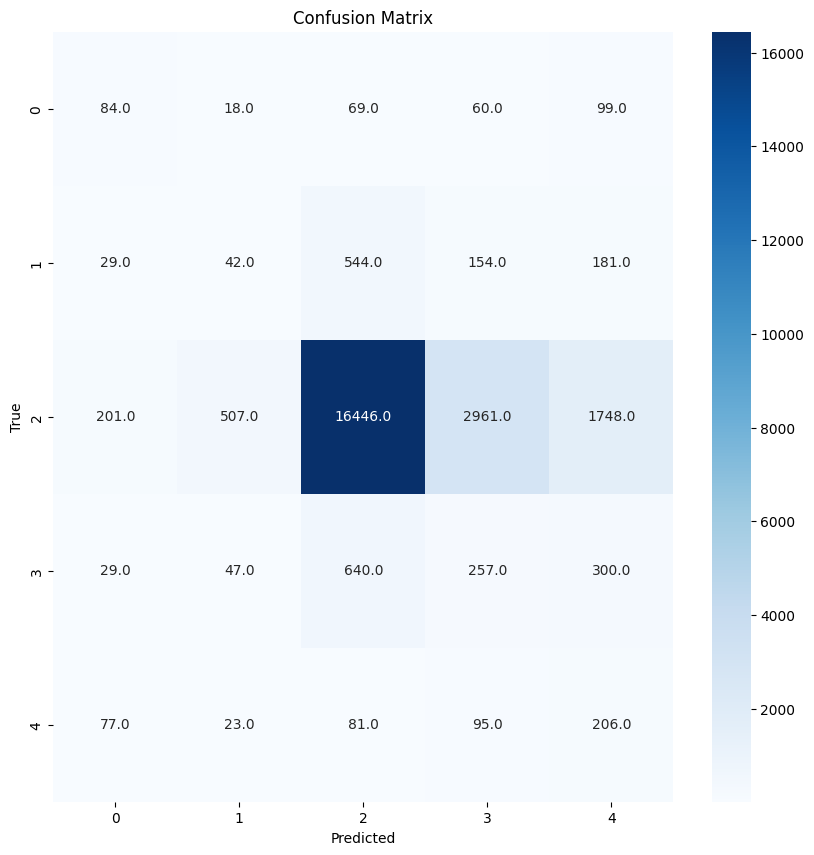

In [14]:
# confusion matrix
print(confusion_matrix(y_test, y_pred))
plot_cm(confusion_matrix(y_test, y_pred))

In [ ]:

y_train_fixed = y_train + 2
y_test_fixed = y_test + 2

classes = np.unique(y_train_fixed)
print(f"Classes: {classes}")
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_fixed)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print(f"Class weights: {class_weight_dict}")

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=5,
    eval_metric="mlogloss",  # Multi-class log loss
    scale_pos_weight=class_weights,  # Handles class imbalance
    seed=42
)

# Train the model
xgb_model.fit(X_train, y_train_fixed)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model
print(classification_report(y_test_fixed, y_pred_xgb))

Classes: [0 1 2 3 4]


c:\Users\jovan\anaconda3\envs\cs7643-a2\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.89      0.48      0.63       330
           1       0.55      0.09      0.15       950
           2       0.91      0.99      0.95     21863
           3       0.74      0.31      0.44      1273
           4       0.82      0.34      0.48       482

    accuracy                           0.90     24898
   macro avg       0.78      0.44      0.53     24898
weighted avg       0.89      0.90      0.88     24898



[[  160    31   123     8     8]
 [    2    85   856     7     0]
 [   14    32 21685   117    15]
 [    2     3   860   394    14]
 [    1     3   303    10   165]]


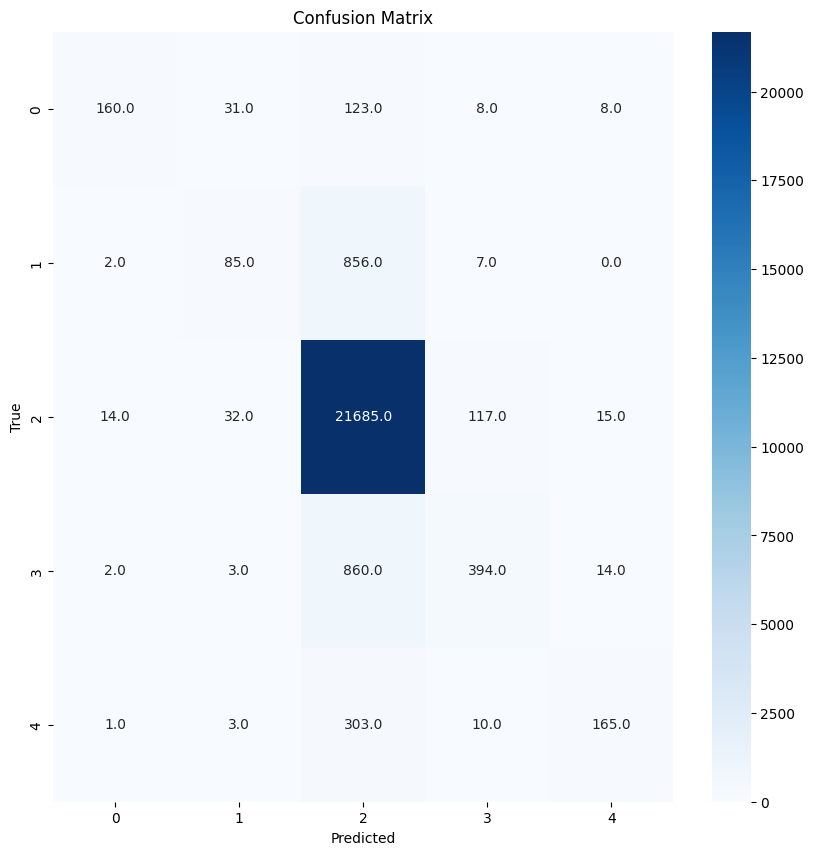

In [16]:
print(confusion_matrix(y_test_fixed, y_pred_xgb))
plot_cm(confusion_matrix(y_test_fixed, y_pred_xgb))

                  Feature  Importance
2          vix_t_7_future    0.009448
9    sentiment_positive_t    0.009002
660  subindustry_25201030    0.006985
725  subindustry_45301010    0.006769
739  subindustry_55103010    0.006622
164            ticker_CZR    0.006503
477            ticker_RIG    0.006438
617  subindustry_10102020    0.006404
471              ticker_R    0.006285
1            vix_t_7_past    0.006251
687  subindustry_30202030    0.006131
673  subindustry_25503030    0.006113
685  subindustry_30201030    0.006105
0                   vix_t    0.006053
653  subindustry_20304040    0.005941
166            ticker_DAY    0.005747
700  subindustry_40101010    0.005742
737  subindustry_55101010    0.005677
717  subindustry_45103010    0.005423
693  subindustry_35102010    0.005417


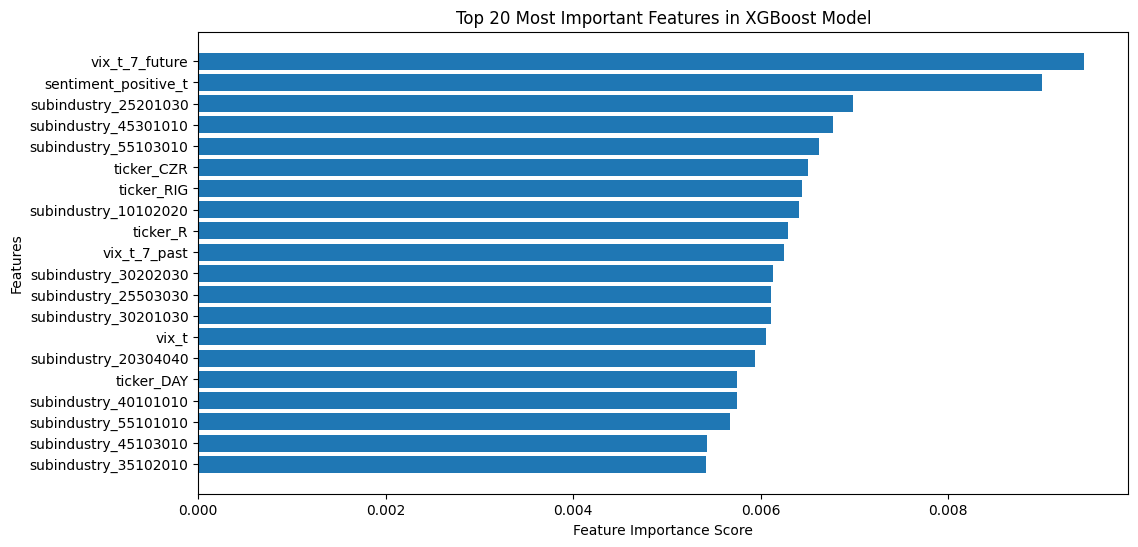

In [17]:
plot_feature_importance(xgb_model.feature_importances_, X_train)

weird okay so both the models did great with training data

are we overfitting? did we memorize?

# TEST

In [18]:
# okay lets load Headlines.weekly_test_data, take it through the same process and see how it does
con = duckdb.connect(r"C:/Users/jovan/Documents/CSE 6748 Practicum WITH DATA/financial_news.db", read_only=True)
df = con.execute("SELECT * FROM Headlines.weekly_test_data").fetchdf()
con.close()

df = df.sort_values(by=["ticker", "date_t"])

# Shift `price_change_t_7` backwards to create `price_change_t_7_future`
df["price_change_t_7_future"] = df.groupby("ticker")["price_change_t_7"].shift(-1)

# Drop rows where `price_change_t_7_future` is NaN (since we don't have future data for the last row)
df = df.dropna(subset=["price_change_t_7_future"])

df["Target_t_7"] = df["price_change_t_7_future"].apply(classify_price_movement)
df = df.drop(columns=["price_change_t_7_future"])

df["Target_t_7"].value_counts() # honestly this is pretty balanced

Target_t_7
 0    34730
-1     2876
 1     2557
 2      949
-2      748
Name: count, dtype: int64

In [19]:
df.head()

,guid,date_t,ticker,subindustry,vix_t,vix_t_7_past,vix_t_7_future,price_t,price_t_7_past,price_change_t_7,volume_t,volume_t_7_past,volume_change_t_7,sentiment_label_t,sentiment_positive_t,sentiment_neutral_t,sentiment_negative_t,Target_t_7
780,fca0839a-68c5-3aaa-9b24-d4dd12306c93,2024-07-29,A,35203010,23.389999,16.389999,23.739477,137.380005,137.320007,0.043692,1222648,1717670,-28.819389,NEGATIVE,1.457781e-05,7.479962e-06,9.999779e-01,-1
3678,None,2024-08-05,A,35203010,20.370001,23.389999,19.445204,134.699997,139.039993,-3.121401,1885243,2298354,-17.974211,NEUTRAL,0.000000e+00,1.000000e+00,0.000000e+00,0
3937,d65967d8-0017-3051-9eb7-6c1f8eca1762,2024-08-12,A,35203010,14.800000,20.370001,15.545537,135.600006,136.899994,-0.949589,1347171,737614,82.639023,POSITIVE,9.977054e-01,5.356342e-07,2.294097e-03,0
5793,466b01e6-880b-3d20-ac96-bd7c22f4916b,2024-08-19,A,35203010,15.860000,14.800000,16.301971,140.509995,140.039993,0.335619,1714023,1284834,33.404237,NEUTRAL,4.793020e-09,1.000000e+00,3.514156e-08,0
7681,a6ffa3a3-8ead-3394-bdbb-6523304b0ae9,2024-08-26,A,35203010,15.000000,15.860000,15.120406,140.490005,140.869995,-0.269745,1013194,1735574,-41.621965,NEGATIVE,2.634196e-04,3.272604e-01,6.724762e-01,0


In [20]:
test_df = df
test_df["volume_change_t_7"] = df["volume_change_t_7"].fillna(0)
categorical_features = ["ticker", "subindustry"]

In [21]:
encoded_cats = encoder.transform(test_df[categorical_features])  # Use trained encoder
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))
test_df = test_df.drop(columns=categorical_features)
test_df = test_df.drop(columns=["guid", "sentiment_label_t"])
date_col = test_df["date_t"].reset_index(drop=True)  # Reset index
target_col = test_df["Target_t_7"].reset_index(drop=True)  # Reset index
test_df_no_date = test_df.drop(columns=["date_t", "Target_t_7"]).reset_index(drop=True)
test_df_no_date.columns

Index(['vix_t', 'vix_t_7_past', 'vix_t_7_future', 'price_t', 'price_t_7_past',
       'price_change_t_7', 'volume_t', 'volume_t_7_past', 'volume_change_t_7',
       'sentiment_positive_t', 'sentiment_neutral_t', 'sentiment_negative_t'],
      dtype='object')

In [22]:
scaled_features = scaler.transform(test_df_no_date)  # Use trained scaler
scaled_df = pd.DataFrame(scaled_features, columns=test_df_no_date.columns)

date_col = test_df["date_t"].reset_index(drop=True)
final_test_df = pd.concat([date_col,target_col, scaled_df, encoded_df], axis=1)
final_test_df.head()

,date_t,Target_t_7,vix_t,vix_t_7_past,vix_t_7_future,price_t,price_t_7_past,price_change_t_7,volume_t,volume_t_7_past,...,subindustry_60105010,subindustry_60106010,subindustry_60106020,subindustry_60107010,subindustry_60108010,subindustry_60108020,subindustry_60108030,subindustry_60108040,subindustry_60108050,subindustry_60201040
0,2024-07-29,-1,0.801450,-0.394006,0.855452,-0.072800,-0.072689,-0.014099,-0.199094,-0.184431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-08-05,0,0.285549,0.801398,0.121612,-0.081663,-0.066996,-1.484456,-0.182053,-0.171299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-08-12,0,-0.665964,0.285667,-0.544794,-0.078687,-0.074079,-0.475532,-0.195891,-0.206595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-08-19,0,-0.484886,-0.665533,-0.415528,-0.062448,-0.063686,0.121517,-0.186456,-0.194220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-08-26,0,-0.631799,-0.484515,-0.617443,-0.062514,-0.060939,-0.159708,-0.204481,-0.184026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# fill nans for 0 for now. don't feel liek fixing it 
final_test_df = final_test_df.fillna(0)

In [24]:
X_test_new = final_test_df.drop(columns=["Target_t_7", "date_t"])
y_test_new = final_test_df["Target_t_7"]

y_pred_new = model.predict(X_test_new)

In [25]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

          -2       0.12      0.12      0.12       748
          -1       0.07      0.03      0.04      2876
           0       0.86      0.75      0.80     34730
           1       0.06      0.16      0.09      2557
           2       0.09      0.24      0.13       949

    accuracy                           0.65     41860
   macro avg       0.24      0.26      0.24     41860
weighted avg       0.73      0.65      0.68     41860



[[   90    35   390   148    85]
 [  110    83  1598   778   307]
 [  435   923 26195  5427  1750]
 [   81    61  1714   417   284]
 [   26    95   504    94   230]]


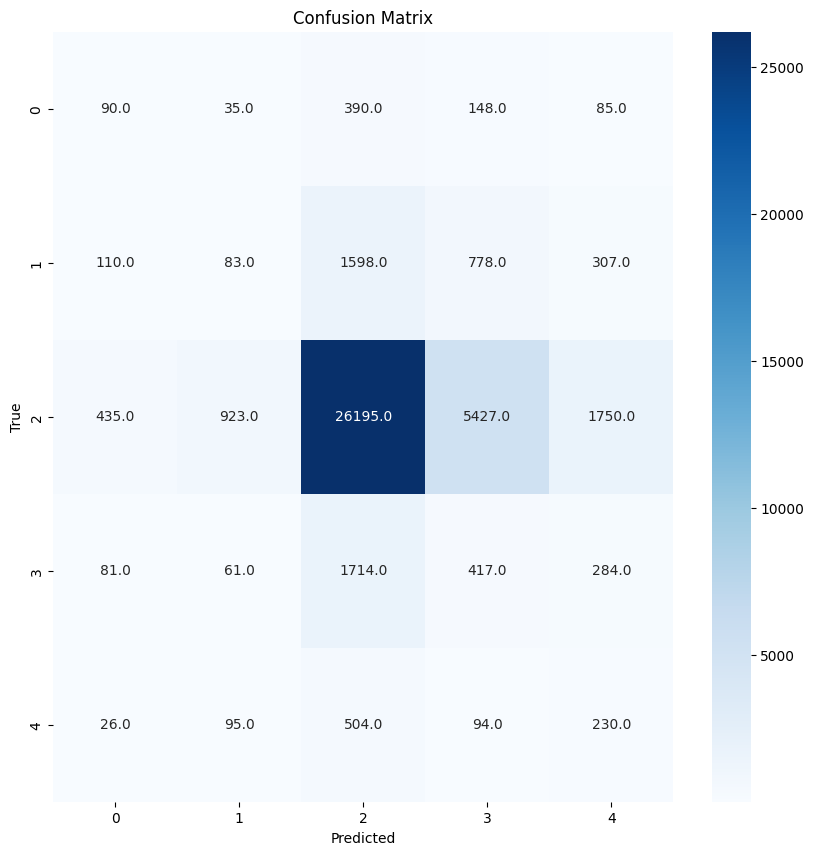

In [26]:
print(confusion_matrix(y_test_new, y_pred_new))
plot_cm(confusion_matrix(y_test_new, y_pred_new))

In [27]:
# now for xgboost
y_test_new_fixed = y_test_new + 2
y_pred_xgb_new = xgb_model.predict(X_test_new)

print(classification_report(y_test_new_fixed, y_pred_xgb_new))

              precision    recall  f1-score   support

           0       0.80      0.35      0.49       748
           1       0.62      0.05      0.10      2876
           2       0.85      0.99      0.92     34730
           3       0.74      0.16      0.26      2557
           4       0.80      0.24      0.37       949

    accuracy                           0.85     41860
   macro avg       0.76      0.36      0.42     41860
weighted avg       0.83      0.85      0.80     41860



[[  261     7   467     7     6]
 [   10   150  2684    20    12]
 [   37    60 34500   112    21]
 [    9    19  2115   397    17]
 [    8     5   707     3   226]]


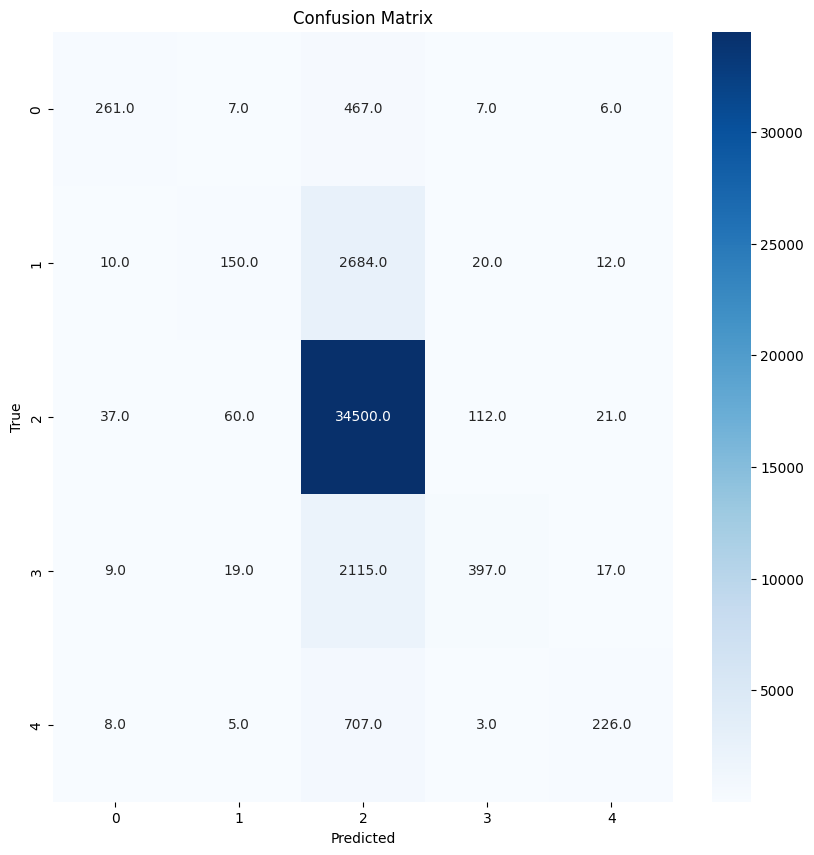

In [28]:
cm = confusion_matrix(y_test_new_fixed, y_pred_xgb_new)
print(cm)
plot_cm(cm)

                  Feature  Importance
2          vix_t_7_future    0.009448
9    sentiment_positive_t    0.009002
660  subindustry_25201030    0.006985
725  subindustry_45301010    0.006769
739  subindustry_55103010    0.006622
164            ticker_CZR    0.006503
477            ticker_RIG    0.006438
617  subindustry_10102020    0.006404
471              ticker_R    0.006285
1            vix_t_7_past    0.006251
687  subindustry_30202030    0.006131
673  subindustry_25503030    0.006113
685  subindustry_30201030    0.006105
0                   vix_t    0.006053
653  subindustry_20304040    0.005941
166            ticker_DAY    0.005747
700  subindustry_40101010    0.005742
737  subindustry_55101010    0.005677
717  subindustry_45103010    0.005423
693  subindustry_35102010    0.005417


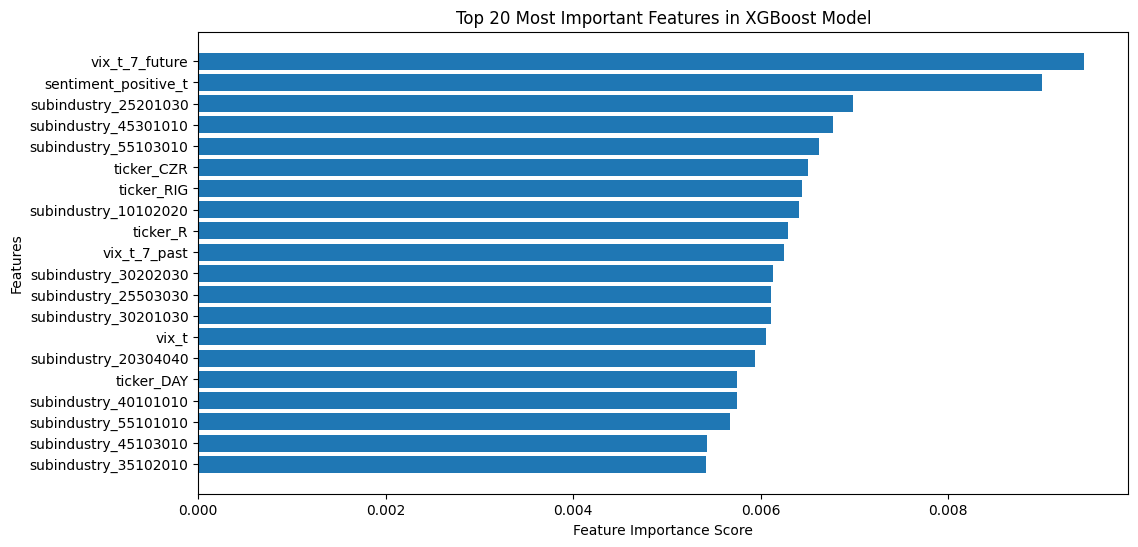

In [29]:

# Get feature importance scores from trained XGBoost model
feature_importance = xgb_model.feature_importances_
plot_feature_importance(feature_importance, X_test_new)